# Modeling All the Fire Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
df1 = pd.read_csv('../../data/processed/wildfire_weather.csv')
df2 = pd.read_csv('../../data/cleaned/land_cover.csv', index_col = 'Unnamed: 0')
df2.rename(columns = {'fire_id': 'id'}, inplace = True)
df = pd.merge(df1, df2, on = 'id')
df.head()

,id,x,y,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,incidenttypecategory,...,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,wind_speed_2m_mean,wind_speed_2m_max_mean,wind_speed_10m_mean,wind_speed_10m_max_mean,humidity_mean,temp_2m_mean,rain_sum,land_cover_class
0,0,-111.348611,33.195755,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,WF,...,0.12,0.38,1.410000,3.090000,1.895000,4.180000,13.210000,29.900000,2.60,474
1,1,-115.748812,40.617506,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.9,5.0,Natural,2020-07-19 23:00:00+00:00,WF,...,0.31,0.37,1.933913,3.914783,2.865217,5.237174,5.657391,23.396304,12.62,489
2,2,-108.193611,39.858486,2020-08-30 00:00:00+00:00,2020-09-10 14:00:00+00:00,0.1,1.0,Natural,2020-08-29 21:46:00+00:00,WF,...,0.26,0.35,1.733846,2.986154,2.993846,4.754615,4.731538,16.121538,27.78,187
3,3,-109.703111,40.227646,2020-10-28 20:15:00+00:00,2020-10-28 20:15:00+00:00,0.1,0.1,Human,2020-10-28 19:37:00+00:00,WF,...,0.17,0.34,1.250000,2.980000,1.880000,4.020000,2.560000,5.480000,0.00,557
4,4,-110.385511,31.961145,2020-07-10 18:14:59+00:00,2020-07-10 18:14:59+00:00,0.1,0.1,Human,2020-07-09 16:34:59+00:00,WF,...,0.15,0.36,3.090000,5.055000,4.265000,6.800000,9.950000,31.235000,0.58,462


In [3]:
for i in df.columns:
    print(i)

id
x
y
containmentdatetime
controldatetime
dailyacres
discoveryacres
firecause
firediscoverydatetime
incidenttypecategory
incidenttypekind
initiallatitude
initiallongitude
irwinid
localincidentidentifier
poocounty
poodispatchcenterid
poofips
poostate
uniquefireidentifier
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
wind_speed_2m_mean
wind_speed_2m_max_mean
wind_speed_10m_mean
wind_speed_10m_max_mean
humidity_mean
temp_2m_mean
rain_sum
land_cover_class


In [4]:
df['firediscoverydatetime'] = pd.to_datetime(df['firediscoverydatetime'])
df['controldatetime'] = pd.to_datetime(df['controldatetime'])
df['containmentdatetime'] = pd.to_datetime(df['containmentdatetime'])

In [5]:
df['time_to_control'] = df['controldatetime'] - df['firediscoverydatetime']
df['time_to_contain'] = df['containmentdatetime'] - df['firediscoverydatetime']

df['minutes_to_control'] = df['time_to_control'].map(lambda x: x.total_seconds()/60)
df['minutes_to_contain'] = df['time_to_contain'].map(lambda x: x.total_seconds()/60)

In [6]:
df['firecause'].value_counts()

Human           9573
Natural         6320
Undetermined    4984
Unknown          641
Name: firecause, dtype: int64

In [7]:
df['firecause'] = df['firecause'].map({'Undetermined': 0, 'Unknown': 0, 'Natural': 1, 'Human' : 2})

---
######
### Investigating Correlation Between the Features and Target (DailyAcres) 
######
___

In [8]:
heatmap_cols = ['dailyacres', 'discoveryacres', 'minutes_to_control','minutes_to_contain', 'firecause', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m',
                'wind_speed_2m_max', 'wind_speed_10m', 'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 'wind_speed_2m_mean',
                'wind_speed_2m_max_mean', 'wind_speed_10m_mean', 'wind_speed_10m_max_mean', 'humidity_mean', 'temp_2m_mean', 'rain_sum', 'land_cover_class']

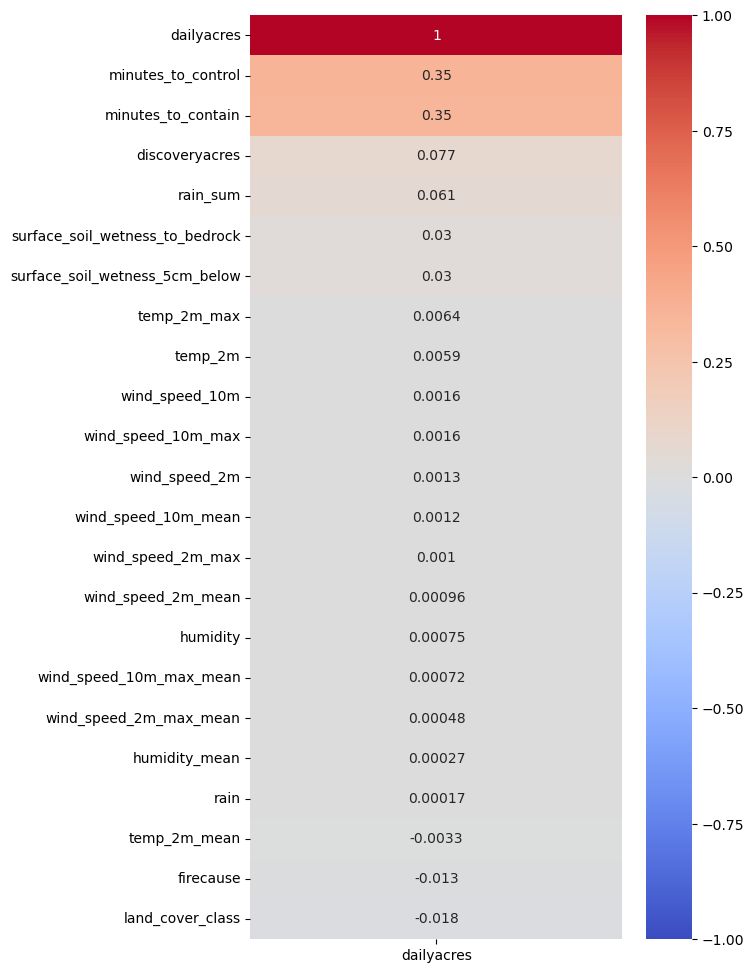

In [9]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[heatmap_cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Briefly Investigating Correlation Between the Features and Target (DailyAcres) for Fires Equal to / Over 1 Acre
######
___

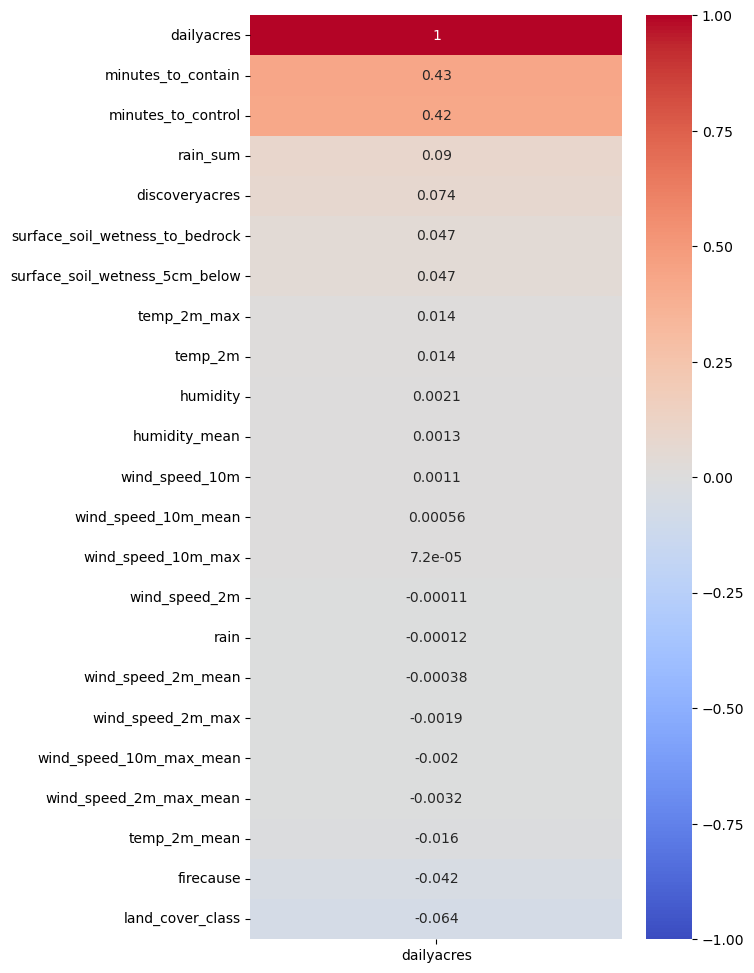

In [10]:
df_over_1_acre = df[df['dailyacres'] >=1.0]
plt.figure(figsize = (6, 12))
sns.heatmap(df_over_1_acre[heatmap_cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

In [11]:
df_over_1_acre.shape

(4905, 42)

In [12]:
df.shape

(21518, 42)

---
######
### Feature Selection, Train/Test Splitting Data, and Standard Scaling
######
___

In [35]:
cols = ['dailyacres', 'discoveryacres', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 'wind_speed_2m_max', 'wind_speed_10m', 'wind_speed_10m_max',
        'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 'wind_speed_2m_mean', 'wind_speed_2m_max_mean', 'wind_speed_10m_mean', 'wind_speed_10m_max_mean',
        'humidity_mean', 'temp_2m_mean', 'rain_sum', 'land_cover_class']


In [36]:
df = df[cols]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'dailyacres'), df['dailyacres'], random_state= 42)

In [37]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

---
######
### Using PCA For Feature Elimination
######
___

In [38]:
pca = PCA(random_state = 42)

Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [39]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:20], 3)

array([0.667, 0.773, 0.852, 0.905, 0.958, 0.99 , 0.997, 0.999, 1.   ,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   ])

In [41]:
Z_train = Z_train[:,:9]
Z_test = Z_test[:,:9]

In [69]:
#Saving the PCA data for investigations in Neural Nets
#np.savetxt('../../data/processed/Neural_Net_Data/X_train_allfires.csv', X_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/X_test_allfires.csv', X_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_train_allfires.csv', Z_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/Z_test_allfires.csv', Z_test, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_train.csv', y_train, delimiter=',')
#np.savetxt('../../data/processed/Neural_Net_Data/y_test.csv', y_test, delimiter=',')

---
######
### Modeling / Simple Models
######
---

#### Linear Regression (Baseline) with DF

In [44]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.05302631951946635
Testing R-Squared: 0.03748600879230257
RMSE: 9514.356635159562


#### Linear Regression (Baseline) with PCA

In [45]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.01094521157588535
Testing R-Squared: 0.007833991080405056
RMSE: 9659.79862673702


In [46]:
def model_eval(model, param_dict, training_data):
    '''
    d
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

#### KNN Regression with DF

In [47]:
#KNN Regressor with X Data
    #Using high n_neighbors trying to combat high variance

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

Best Score: 0.022053459421078614
Best Params: {'n_neighbors': 1000, 'weights': 'distance'}
RMSE: 9596.874908033386
Training R-Squared: 0.9994216487641527
Testing R-Squared: 0.020717787296154477


#### KNN Regression with PCA Data

In [48]:
#KNN Regressor with PCA Data
    #Using high n_neighbors trying to combat high variance

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

Best Score: 0.022592615109049863
Best Params: {'n_neighbors': 1000, 'weights': 'distance'}
RMSE: 9591.074253201468
Training R-Squared: 0.9994216487628944
Testing R-Squared: 0.02190124783367442


#### Lasso Regression with DF

In [59]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(1, 10)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: 0.03280887726152004
Best Params: {'alpha': 1}
RMSE: 9537.76278570635
Training R-Squared: 0.04046841171774218
Testing R-Squared: 0.03274444620592554


C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+11, tolerance: 4.706e+07
  model = cd_fast.enet_coordinate_descent(


#### Lasso Regression with PCA

In [60]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(90, 200, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.005758451308905998
Best Params: {'alpha': 114}
RMSE: 9645.323993344986
Training R-Squared: 0.008444970739030833
Testing R-Squared: 0.01080516678840393


#### Adaboost Regression with DF

In [63]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 81, 10),
    'learning_rate': np.linspace(0.01, .25, 10) 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -0.04029986624788111
Best Params: {'learning_rate': 0.08999999999999998, 'n_estimators': 40}
RMSE: 9163.81142250772
Training R-Squared: 0.7298694428500847
Testing R-Squared: 0.10710480625283525


#### Adaboost Regression with PCA

In [62]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(10, 101, 10),
    'learning_rate': np.linspace(0.2, .75, 10) 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: 0.025035429384642493
Best Params: {'learning_rate': 0.4444444444444445, 'n_estimators': 20}
RMSE: 9058.74473272461
Training R-Squared: 0.7408167584447627
Testing R-Squared: 0.12746221727163864


---
######
### Modeling / Ensemble Models
######
---

#### Stacking Regression with DF and with DecisionTreeRegressor Final Estimator

In [54]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -0.5050915692869558
Testing R-Squared: -0.19302000971306454
RMSE: 10592.531514659491


#### Stacking Regression with PCA and with DecisionTreeRegressor Final Estimator

In [53]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.3673501265838599
Testing R-Squared: -0.4501559079356432
RMSE: 11678.397382640584


#### Stacking Regression with DF and with LinearRegression Final Estimator

In [66]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: 0.40313037814022934
Testing R-Squared: 0.05359503716353908
RMSE: 9434.402603024637


#### Stacking Regression with PCA and with LinearRegression Final Estimator

In [55]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.4180682684983795
Testing R-Squared: 0.054591009218659114
RMSE: 9429.437035877161


#### Stacking Regression with PCA and with Lasso Final Estimator

In [56]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.3954483144549096
Testing R-Squared: 0.05667177730731299
RMSE: 9419.054609048755


#### Stacking Regression (different base estimators) with PCA and with LinearRegression Final Estimator

In [57]:
# Stacking Regressor

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.28413288442380635
Testing R-Squared: 0.041269829078196874
RMSE: 9495.636872664436


#### Voting Regression with PCA

In [67]:
#Voting Regression

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.6160830205117735
Testing R-Squared: 0.09392815875503135
RMSE: 9231.179963320672
